# Chicago Divvy Bike Ride-Sharing Analysis

![alt text](images/divvy.jpg)

### Introduction
This notebook is based on the [Divvy Ride-Sharing Kaggle dataset and competition](https://www.kaggle.com/yingwurenjian/chicago-divvy-bicycle-sharing-data) for Divvy bike rides in Chicago, IL. It's a re-creation of a program I created about a year ago that was lost when a hard drive died and I've since learned my lesson so this is going straight to git. Some of the features of the previous program will be implemented but I really want to try to divide the notebooks more atomically so that each serves a pretty specific purpose and doesn't have too large of scope. 

### Goals of the Notebook
 * Conditionally split dataset
 * Determine which stations are busiest/where they usually lead to
 * Show distributions of the data, branch out with Seaborn library
 * Map rides using Basemap--really improve my skills with that
 * Perform machine learning and create models using Scikit-Learn
 

### Importing 
Just a typical data science library stack for the EDA notebook.

In [1]:
import random

import numpy   as np
import pandas  as pd
import seaborn as sns
import matplotlib.pyplot as plt

#pip3 install https://github.com/matplotlib/basemap/archive/master.zip

### CSV File Exploration and Importing

The first thing we'll do is peer into the csv files provided by Kaggle to see what kind of data we're looking at. Since the data is incredibly large (don't have a week for operating on 9 million divvy bike rides), for this stage of the analysis we'll just take a random sampling from the data.

To randomize the import I'm just going to retrieve every 1/n lines from the file. 

In [31]:
!wc data/data.csv
!wc data/data_raw.csv

 9495236 105797302 2084674565 data/data.csv
 13774716 160096066 3483195736 data/data_raw.csv


In [2]:
n = 1000

csv_filename = 'data/data.csv'
num_lines = sum(1 for l in open(csv_filename))

skip_ix = [x for x in range(1, num_lines) if x % n != 0]

data_df = pd.read_csv(
    csv_filename,
    skiprows=skip_ix
)

print("Columns in List: \n")
for column in list(data_df):
    print(column)

Columns in List
trip_id
year
month
week
day
hour
usertype
gender
starttime
stoptime
tripduration
temperature
events
from_station_id
from_station_name
latitude_start
longitude_start
dpcapacity_start
to_station_id
to_station_name
latitude_end
longitude_end
dpcapacity_end


In [33]:
data_df.head()

,trip_id,year,month,week,day,hour,usertype,gender,starttime,stoptime,...,from_station_id,from_station_name,latitude_start,longitude_start,dpcapacity_start,to_station_id,to_station_name,latitude_end,longitude_end,dpcapacity_end
0,2353212,2014,6,27,0,17,Subscriber,Male,2014-06-30 17:47:00,2014-06-30 17:52:00,...,51,Clark St & Randolph St,41.884576,-87.631890,31.0,43,Michigan Ave & Washington St,41.883893,-87.624649,43.0
1,2351643,2014,6,27,0,16,Subscriber,Male,2014-06-30 16:57:00,2014-06-30 17:03:00,...,49,Dearborn St & Monroe St,41.881320,-87.629521,27.0,91,Clinton St & Washington Blvd,41.883380,-87.641170,31.0
2,2349620,2014,6,27,0,14,Subscriber,Male,2014-06-30 14:58:00,2014-06-30 15:03:00,...,197,Michigan Ave & Madison St,41.882134,-87.625125,19.0,174,Canal St & Madison St,41.882091,-87.639833,23.0
3,2347261,2014,6,27,0,11,Subscriber,Female,2014-06-30 11:37:00,2014-06-30 11:52:00,...,211,St Clair St & Erie St,41.894448,-87.622663,19.0,49,Dearborn St & Monroe St,41.881320,-87.629521,27.0
4,2345061,2014,6,27,0,8,Subscriber,Male,2014-06-30 08:31:00,2014-06-30 08:40:00,...,264,Stetson Ave & South Water St,41.886835,-87.622320,19.0,321,Wabash Ave & 8th St,41.871962,-87.626106,19.0


In [34]:
data_df.describe()

,trip_id,year,month,week,day,hour,tripduration,temperature,from_station_id,latitude_start,longitude_start,dpcapacity_start,to_station_id,latitude_end,longitude_end,dpcapacity_end
count,9.495000e+03,9495.000000,9495.000000,9495.000000,9495.000000,9495.000000,9495.000000,9495.000000,9495.000000,9495.000000,9495.000000,9495.000000,9495.000000,9495.000000,9495.000000,9495.000000
mean,9.861927e+06,2015.737441,7.161559,29.383149,2.684887,13.630542,11.352547,63.011448,179.279305,41.900204,-87.644597,21.380832,179.651395,41.900417,-87.644647,21.259400
std,4.680399e+06,1.075634,2.708081,11.776481,1.890381,4.851057,7.110063,17.200150,121.730907,0.034862,0.021657,7.577247,122.679316,0.035232,0.021766,7.517441
min,1.110978e+06,2014.000000,1.000000,1.000000,0.000000,0.000000,2.000000,-9.900000,2.000000,41.746559,-87.802870,11.000000,2.000000,41.746559,-87.802240,9.000000
25%,5.943099e+06,2015.000000,5.000000,21.500000,1.000000,9.000000,6.025000,52.000000,76.000000,41.881032,-87.654787,15.000000,75.000000,41.881032,-87.654787,15.000000
50%,1.005992e+07,2016.000000,7.000000,30.000000,3.000000,15.000000,9.616667,66.900000,164.000000,41.892278,-87.641066,19.000000,164.000000,41.892570,-87.641066,19.000000
75%,1.383330e+07,2017.000000,9.000000,38.000000,4.000000,17.000000,14.900000,75.900000,268.000000,41.920082,-87.629928,23.000000,272.000000,41.920771,-87.629928,23.000000
max,1.753603e+07,2017.000000,12.000000,53.000000,6.000000,23.000000,59.350000,95.000000,625.000000,42.063598,-87.559275,55.000000,625.000000,42.063999,-87.565688,55.000000


**Thoughts:** There are a few really interesting features contained within the dataset that I'll want to explore moving foward in this notebook. I'll break the features down sort of categorically here.

**Geographical:**
 * from_station_id
 * from_station_name
 * latitude_start
 * longitude_start
 * to_station_id
 * to_station_name
 * latitude_end
 * longitude_end
 
**Weather:**
 * temperature
 * events
 
**Datetime:**
 * year
 * month
 * week
 * day
 * hour
 * starttime
 * stoptime
 * tripduration
 
**User-Specific:**
 * usertype
 * gender

### Plotting and Distribution of Features

In [36]:
def plot_columns(df, x_col, y_col):
    plt.figure(figsize=(6,6))
    
    plt.scatter(
        x=df[x_col],
        y=df[y_col],
        s=2
    )
    
    plt.title('{} correlation with {}'.format(x_col.upper(), y_col.upper()))
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    
    plt.show()

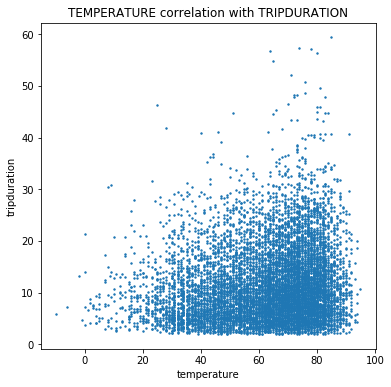

In [37]:
corr_targets = [
    ('temperature', 'tripduration'),
]

for target in corr_targets:
    plot_columns(data_df, target[0], target[1])

In [38]:
def distribution(df, col):
    
    plt.figure(figsize=(5,5))
    
    sns.distplot(df[col])
    plt.title('Distribution of {}'.format(col.upper()))

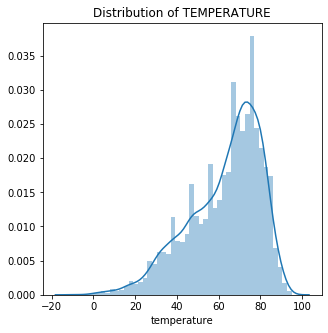

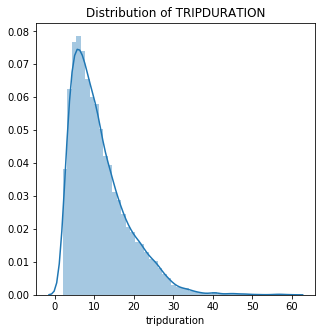

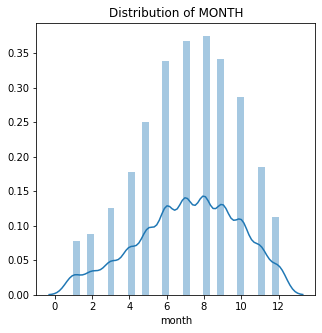

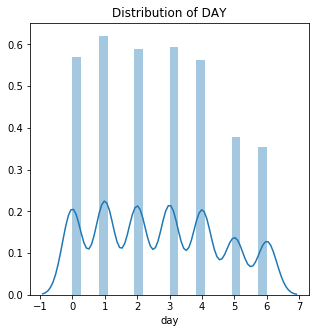

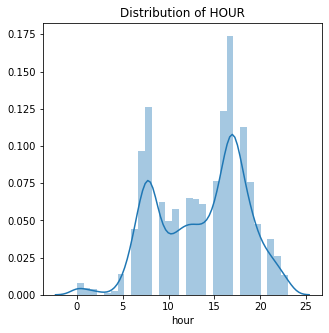

In [39]:
dist_targets = [
    'temperature',
    'tripduration',
    'month',
    'day',
    'hour',
    
]

for target in dist_targets:
    distribution(data_df, target)